# Classifier Model - LDA Feature Vector

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
def get_data(data_file_path):
    excel_file_obj = pd.ExcelFile(data_file_path)
    # print(excel_file_obj.sheet_names)
    # get all endpoints
    endpoint_df = excel_file_obj.parse("EPs ")
    endpoints = endpoint_df.loc[:, "Short Name"]
    frames = []
    for endpoint in endpoints:
        df = excel_file_obj.parse(endpoint+" PT")
        frames.append(df.loc[:,['Endpoint', 'MedDRA Preferred Term (PT)']])
    return pd.concat(frames)

def print_stats(df):
    print(f"No of rows in the dataset:{df.shape}")

data_file_path_2020 = os.path.join("data","Master List of Preferred Term v21 2020_03_19.xlsx")
data_file_path_2019 = os.path.join("data","Master List of Preferred Term v20 2019-10-23.xlsx")

df1 = get_data(data_file_path_2019)
df2 = get_data(data_file_path_2020)

print_stats(df1)
print_stats(df2)

No of rows in the dataset:(1396, 2)
No of rows in the dataset:(1409, 2)


In [6]:
## Data Cleaning

frames = [df1, df2]
df = pd.concat(frames)
print_stats(df)

No of rows in the dataset:(2805, 2)


In [7]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re

## Remove punctuation and lower casing

stemmer = PorterStemmer()
words = stopwords.words("english")

df['Processed-MedDRA Preferred Term (PT)'] = df['MedDRA Preferred Term (PT)'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [11]:
df["Processed-MedDRA Preferred Term (PT)"].shape

(2805,)

In [13]:
## lets see word cloud
## cant install word cloud

In [14]:
## Prepare text for LDA analysis

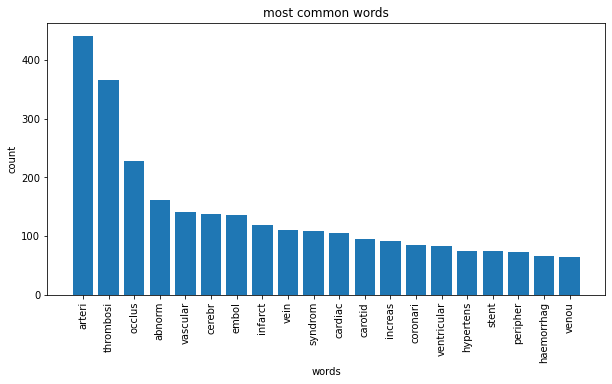

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 


def plot_most_common_words(count_data,count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))

    for t in count_data:
        total_counts+=t.toarray()[0]

    count_dict = zip(words,total_counts)
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:20]

    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize = (10,5))
    plt.title("most common words")
    plt.bar(x_pos,counts)
    plt.xticks(x_pos, words, rotation=90) 

    plt.xlabel("words")
    plt.ylabel("count")
    plt.show()

count_vectorizer = CountVectorizer(stop_words="english")
count_data = count_vectorizer.fit_transform(df["Processed-MedDRA Preferred Term (PT)"])

plot_most_common_words(count_data, count_vectorizer)


In [97]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# two parameters, number of topics, and number of words per topic
number_topics = 6
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
cerebr carotid arteri haemorrhag pulmonari heart infarct spinal vena myocardi

Topic #1:
arteri occlus vascular coronari stent mesenter peripher bypass diseas insert

Topic #2:
thrombosi vein venou occlus sinu stroke devic site infarct stem

Topic #3:
hypertens increas blood pressur angioplasti intracrani brain abnorm atrial vessel

Topic #4:
syndrom cardiac abnorm pancreat electrocardiogram acut increas arrhythmia failur oper

Topic #5:
embol ventricular infarct abnorm right cerebrovascular cerebr procedur ischaemia renal


### TSNE Plot for Topics

In [98]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


In [99]:
lda.components_

array([[ 0.16666876,  0.16673989,  0.16666764, ...,  0.16666763,
         0.16667061,  0.16666763],
       [ 0.16666829,  0.1667227 ,  0.16666742, ...,  0.16666741,
         0.16666971,  0.16666741],
       [ 0.16666838,  0.16666823,  0.16666747, ...,  0.16666745,
         0.16666989,  0.16666745],
       [ 0.16666917, 18.16599628,  0.16666783, ...,  0.16666782,
         2.16723159,  0.16666782],
       [ 2.16665653,  0.16702762,  0.16666769, ...,  2.16666201,
         2.16608738,  2.16666201],
       [ 0.16666887,  0.16684528,  2.16666196, ...,  0.16666768,
         0.16667081,  0.16666768]])

In [100]:
# Get topic weights
topic_weights = lda.components_

In [101]:
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values


In [102]:
topic_weights.shape


(6, 703)

In [103]:
topic_num = np.argmax(topic_weights, axis=0)
topic_num

array([4, 3, 5, 4, 4, 5, 0, 2, 2, 5, 1, 0, 2, 4, 4, 2, 2, 1, 3, 0, 4, 3,
       0, 4, 2, 4, 1, 5, 0, 1, 0, 2, 5, 5, 0, 3, 2, 2, 4, 1, 0, 4, 5, 3,
       2, 4, 4, 3, 5, 0, 1, 4, 4, 1, 3, 3, 3, 0, 2, 1, 5, 3, 1, 0, 1, 5,
       3, 2, 0, 2, 3, 4, 4, 3, 5, 0, 2, 0, 3, 0, 5, 0, 2, 3, 0, 0, 2, 3,
       5, 1, 3, 2, 5, 4, 3, 2, 0, 4, 2, 1, 5, 0, 5, 4, 4, 4, 2, 0, 3, 0,
       5, 2, 3, 3, 5, 0, 4, 2, 5, 0, 3, 2, 2, 1, 3, 5, 0, 2, 5, 4, 0, 1,
       3, 1, 5, 5, 3, 2, 4, 5, 5, 1, 1, 2, 1, 1, 0, 5, 4, 5, 3, 0, 2, 1,
       4, 0, 4, 0, 0, 4, 2, 2, 2, 3, 0, 1, 2, 1, 5, 5, 5, 1, 5, 3, 1, 3,
       0, 3, 3, 3, 0, 2, 0, 4, 0, 5, 2, 5, 5, 4, 3, 3, 1, 5, 4, 1, 1, 5,
       3, 2, 4, 4, 3, 5, 4, 3, 0, 5, 3, 4, 5, 5, 5, 0, 4, 3, 2, 3, 0, 4,
       1, 5, 5, 0, 0, 3, 1, 3, 0, 3, 0, 4, 4, 4, 0, 1, 4, 2, 3, 2, 2, 2,
       2, 4, 3, 2, 4, 2, 4, 5, 1, 2, 0, 3, 4, 2, 4, 3, 0, 1, 3, 2, 4, 5,
       3, 5, 4, 5, 4, 3, 1, 3, 2, 1, 0, 0, 0, 3, 5, 0, 4, 4, 3, 5, 3, 2,
       1, 1, 0, 4, 5, 5, 2, 2, 4, 4, 1, 3, 1, 1, 0,

In [104]:
## tSNE dimension reduction
import matplotlib.colors as mcolors
tsne_model = TSNE(n_components = 2, verbose = 1, random_state = 0, angle = .99, init = 'pca')
tsne_lda = tsne_model.fit_transform(topic_weights.reshape(703,number_topics))

## topic clusters plot using Bokeh! :) 
# number_topics
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 703 samples in 0.001s...
[t-SNE] Computed neighbors for 703 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 703 / 703
[t-SNE] Mean sigma: 0.000007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.955212
[t-SNE] KL divergence after 1000 iterations: 0.378916


(703, 2)

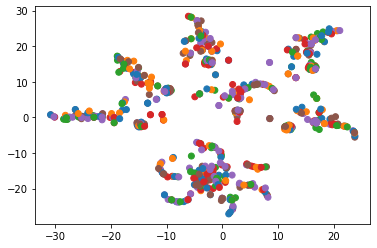

In [105]:

plt.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
plt.show()